<center><img src="https://images.unsplash.com/photo-1620714223084-8fcacc6dfd8d?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=871&q=80" width="720"></center>

<center><font size=6>Credit Card Customer Segmentation</font></center>

## Problem Statement

### Business Context

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

### Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

###  Data Description

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

**Data Dictionary**

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of Visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

## Importing necessary libraries

In [2]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to perform t-SNE
from sklearn.manifold import TSNE

# to define a common seed value to be used throughout
RS=0

# to suppress warnings
import warnings
warnings.filterwarnings("ignore")

## Loading the dataset

In [4]:
# loading the dataset
customer_data = pd.read_csv(r"C:\Users\saura\Downloads\Credit_Card.csv")
pd

<module 'pandas' from 'C:\\Users\\saura\\anaconda3\\Lib\\site-packages\\pandas\\__init__.py'>

In [5]:
# copying the data to another variable to avoid any changes to original data
df = customer_data.copy()

## Data Overview

In [10]:
# viewing the first 5 rows of the data
df.head()

,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


### Checking the data types of the columns for the dataset.

In [13]:
# checking datatypes and number of non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                655 non-null    int64
 1   Customer_Key         655 non-null    int64
 2   Avg_Credit_Limit     655 non-null    int64
 3   Total_Credit_Cards   655 non-null    int64
 4   Total_visits_bank    655 non-null    int64
 5   Total_visits_online  655 non-null    int64
 6   Total_calls_made     655 non-null    int64
dtypes: int64(7)
memory usage: 35.9 KB


- All the columns in the data are numeric.

### Checking for missing values

In [17]:
# checking for missing values
df.isnull().sum()

Sl_No                  0
Customer_Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

- There are no missing values in the data.

In [20]:
df.drop(columns=["Sl_No", "Customer_Key"], inplace=True)

### Checking the Statistical Summary

In [57]:
# Let's look at the statistical summary of the data #transpose (T)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,655.0,34242.748092,37240.896986,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,655.0,4.691603,2.169325,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,655.0,2.401527,1.633648,0.0,1.0,2.0,4.0,5.0
Total_visits_online,655.0,2.606107,2.940380,0.0,1.0,2.0,4.0,15.0
Total_calls_made,655.0,3.601527,2.867352,0.0,1.0,3.0,5.0,10.0


### Outlier Check



- Let's check for outliers in the data.

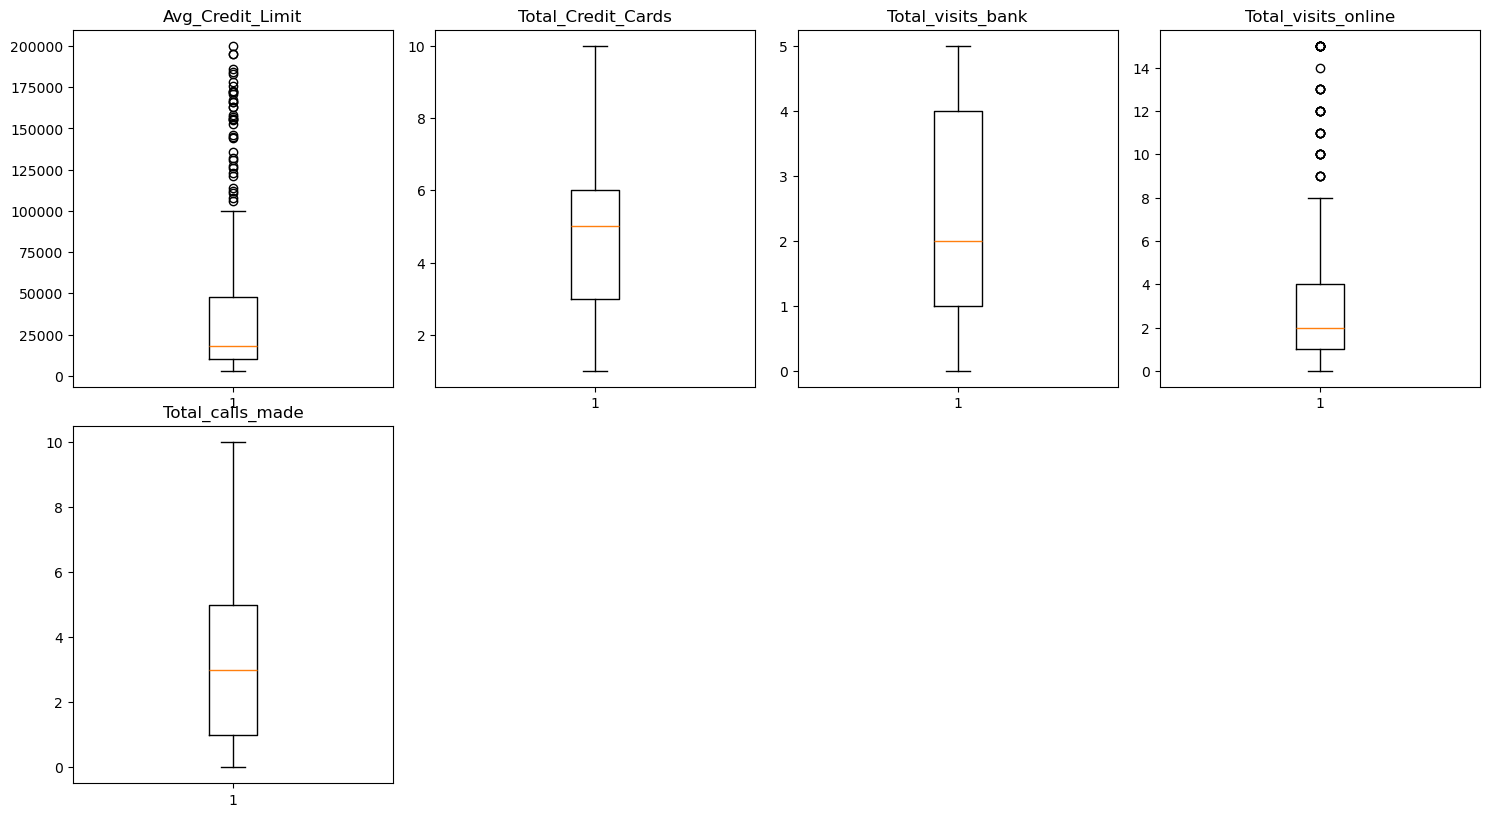

In [27]:
# outlier detection using boxplot #whisker
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(3, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

**Observations**

- There are outliers in the columns *Avg_Credit_Limit* and *Total_Visits_online*.
- We will not treat the outliers as most of those outliers are not disjoint from the curve (continues curve).
- These outliers might also form their own cluster.

### Scaling
#Data normalize


In [31]:
# scaling the data before clustering
scaler = StandardScaler()
subset_scaled = scaler.fit_transform(df)
subset_scaled

array([[ 1.76707628, -1.24170449, -0.85856807, -0.54664171, -1.25700595],
       [ 0.42344023, -0.78037922, -1.47116294,  2.51652641,  1.88417679],
       [ 0.42344023,  1.06492183, -0.85856807,  0.13406232,  0.13907527],
       ...,
       [ 2.97634873,  1.52624709, -0.85856807,  2.1761744 , -0.90798565],
       [ 3.70191219,  2.44889762, -0.85856807,  4.21828648, -1.25700595],
       [ 3.56754859,  1.98757236, -1.47116294,  3.19723044, -0.55896534]])

In [33]:
subset_scaled_df = pd.DataFrame(subset_scaled, columns=df.columns)
subset_scaled_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.767076,-1.241704,-0.858568,-0.546642,-1.257006
1,0.423440,-0.780379,-1.471163,2.516526,1.884177
2,0.423440,1.064922,-0.858568,0.134062,0.139075
3,-0.114014,0.142271,-0.858568,-0.546642,0.139075
4,1.767076,0.603597,-1.471163,3.197230,-0.209945


## Model Building

In [69]:
pip install yellowbrick 

Note: you may need to restart the kernel to use updated packages.


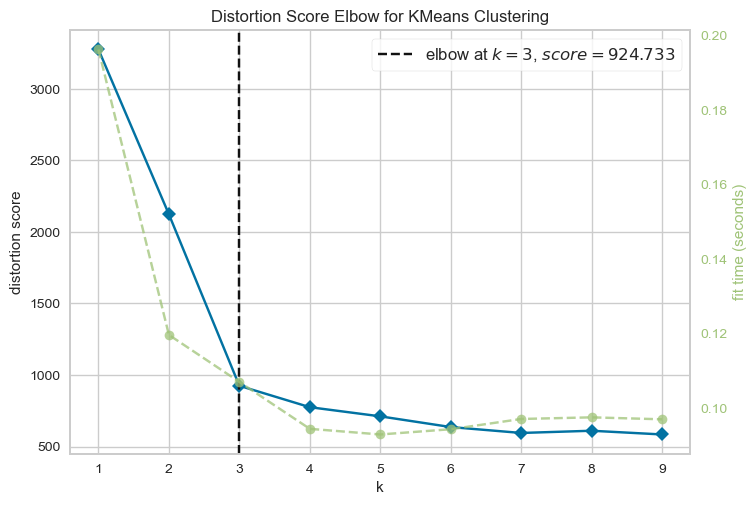

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [87]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(1,10),timings=True)
visualizer.fit(subset_scaled_df)        # Fit the data to the visualizer
visualizer.show()

**Observations**

- The appropriate value of k from the Elbow curve seems to be 3

In [95]:
kmeans = KMeans(n_clusters=3, random_state=10)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=3, random_state=10)

In [91]:
df["K_means_segments"] = kmeans.labels_    # original

df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments
0,100000,2,1,1,0,0
1,50000,3,0,10,9,2
2,50000,7,1,3,4,0
3,30000,5,1,1,4,0
4,100000,6,0,12,3,1


## Cluster Profiling

### Visualizing Final Clusters

In [93]:
km_cluster_profile = df.groupby("K_means_segments").mean()
km_cluster_profile["No. of Customer"] = df.K_means_segments.value_counts()
km_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,No. of Customer
K_means_segments,,,,,,
0,33604.712042,5.505236,3.494764,0.976440,2.005236,382
1,140102.040816,8.775510,0.591837,10.979592,1.102041,49
2,12174.107143,2.410714,0.933036,3.553571,6.870536,224


In [ ]:
num_col = df.select_dtypes(include=np.number).columns.to_list()
num_col

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for i in range(5):
    sns.boxplot(ax=axes[i], y=df[num_col[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

Cluster 0:

- Moderate average credit limit.
- Moderate number of total credit cards.
- Moderate number of visits to the bank.
- Low online interactions.
- Moderate number of calls made.
- Contains a relatively large number of customers (382)

Cluster 1:

- Low average credit limit.
- Low number of total credit cards.
- Low number of visits to the bank.
- Moderate online interactions.
- High number of calls made
- Contains a moderate number of customers (224)

Cluster 2:

- High average credit limit.
- High number of total credit cards.
- Very low number of visits to the bank.
- Very high online interactions.
- Very low number of calls made.
- Contains a small number of customers (49)

## Business Insights and Recommendations

**Cluster 0**

Recommendation: Focus on In-Person Services

- Cluster 0 consists of customers who prefer visiting the bank for their banking needs. Since they have an average credit limit and number of credit cards, there is an opportunity to increase revenue by focusing on the volume of customers in this cluster.
- Consider enhancing the in-branch experience, providing personalized assistance, and offering tailored products to meet the needs of these customers who prefer face-to-face interactions.



**Cluster 1**

Recommendation: Incentivize Online Banking

- Premium customers in Cluster 1 have the potential to add more revenue to the bank. To capitalize on this, the bank should run incentives, promotions, and discounts to encourage more customers to adopt online banking and paperless billing.
- Implement marketing campaigns highlighting the benefits of online banking, such as convenience, time-saving, and exclusive offers for premium customers.


**Cluster 2**

Recommendation: Automation and Expansion of online Banking

- Cluster 2 shows a very high level of online interactions, it is essential to invest in and enhance the online customer experience. This could include improving the user interface of online platforms, providing personalized online offers, and ensuring a seamless digital journey.
- Given the high average credit limit in this cluster, consider tailoring credit limit increase offers for customers who fall within similar profiles.
- Consider expanding online banking services to popular chat applications like WhatsApp and Telegram to provide customers with more flexibility and convenience in their interactions.